In [22]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import sweetviz as sv
import plotly.graph_objs as pg
import plotly.figure_factory as ffc
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier




In [23]:
 #-----------SPRACOVANIE DAT--------------#

df = pd.read_csv("weather_data.csv")
test_data = pd.read_csv("weather_data.csv")

# najskor pridam do irradiance vsade 0 aby sa neodstranilo prilis vela zaznamov

df["Irradiance"] = df["Irradiance"].fillna(0.0)

# zistili sme ze v nasom datasete sa nachádza 277 null hodnôt okrem (stlpca Irradiance)
# pre dataset nasich rozmerov je to pomerne mali pocet zaznamov a preto sme sa 
# ich rozhodli odstranit
print(f"There are: {df.isnull().sum().sum()} null values in dataset")

# Konvertovanie stĺpca 'UV Index' na číselný typ
df['UV Index'] = pd.to_numeric(df['UV Index'], errors='coerce')


print(df.isnull().sum())

# odstranenie prazdnych zaznamov

df = df.dropna()
df = df.drop_duplicates(keep='first')
df = df.fillna(0)

df = df.drop('Irradiance', axis=1)




There are: 277 null values in dataset
Temperature             44
Humidity                35
Wind Speed              38
Precipitation (%)       33
Cloud Cover              0
Atmospheric Pressure    44
UV Index                37
Season                   0
Visibility (km)         47
Location                 0
Weather Type             0
Irradiance               0
dtype: int64


In [24]:
# zistenie kolko roznych druhov Cloud Cover sa nachadza v DB a ich zakodovnie
# Cloud Cover sme si vybrali druh kodovanie: Label Encoding 

unique_values_cloud = df['Cloud Cover'].unique()
print(f"Unique words: {unique_values_cloud}")
print(f"Number of unique words cloud: {len(unique_values_cloud)}")

df['Cloud Cover'] = pd.factorize(df['Cloud Cover'])[0]

unique_values_location = df['Location'].unique()
print(f"Unique words: {unique_values_location}")
print(f"Number of unique words location: {len(unique_values_location)}")

df['Location'] = pd.factorize(df['Location'])[0]

# na stlpec season sme vybrali druh zakódovania One-Hot Encoding

df_one_hot = pd.get_dummies(df['Season'], prefix='Season')
df = pd.concat([df, df_one_hot], axis = 1)

df = df.drop(columns=['Season'])


df['Season_Winter'] = pd.to_numeric(df['Season_Winter'], errors='coerce')
df['Season_Summer'] = pd.to_numeric(df['Season_Summer'], errors='coerce')
df['Season_Autumn'] = pd.to_numeric(df['Season_Autumn'], errors='coerce')
df['Season_Spring'] = pd.to_numeric(df['Season_Spring'], errors='coerce')

# Zobrazenie dátových typov každého stĺpca
print(df.dtypes)

# Vyfiltrovanie stĺpcov, ktoré nie sú číselného typu (float alebo int)
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
print("Stĺpce, ktoré nie sú číselného typu:", non_numeric_columns)



Unique words: ['partly cloudy' 'clear' 'overcast' 'cloudy']
Number of unique words cloud: 4
Unique words: ['inland' 'mountain' 'coastal' 'island']
Number of unique words location: 4
Temperature             float64
Humidity                float64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover               int64
Atmospheric Pressure    float64
UV Index                float64
Visibility (km)         float64
Location                  int64
Weather Type             object
Season_Autumn             uint8
Season_Spring             uint8
Season_Summer             uint8
Season_Winter             uint8
dtype: object
Stĺpce, ktoré nie sú číselného typu: Index(['Weather Type', 'Season_Autumn', 'Season_Spring', 'Season_Summer',
       'Season_Winter'],
      dtype='object')


In [25]:
# Vyhľadanie duplicitných záznamov

duplicate = df[df.duplicated()]
df = df.drop_duplicates()
print("Number of records in dataset: "+str(len(df)))
print("There are: " + str(len(duplicate)) + " duplicates.")



Number of records in dataset: 12924
There are: 0 duplicates.


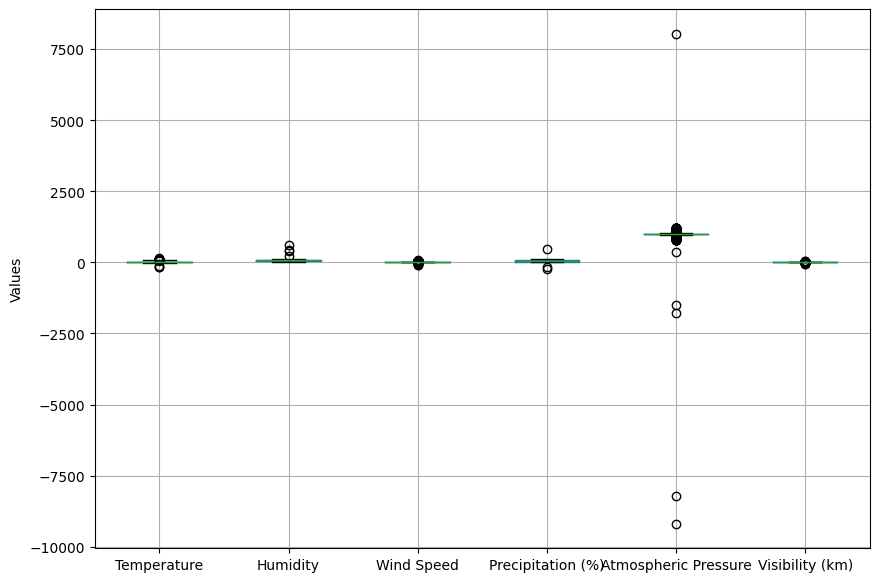

In [26]:
# Teraz potrebujeme odstrániť outliery v stĺpcos v ktorých boli originálne numerické hodnoty

numeric_columns = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)'
                   , 'Atmospheric Pressure', 'Visibility (km)'
                  ]

# vypisanie hodnot ako boxplot
df.boxplot(column=['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)'
                   , 'Atmospheric Pressure', 'Visibility (km)'],figsize=(10,7))
plt.ylabel("Values")
plt.show()

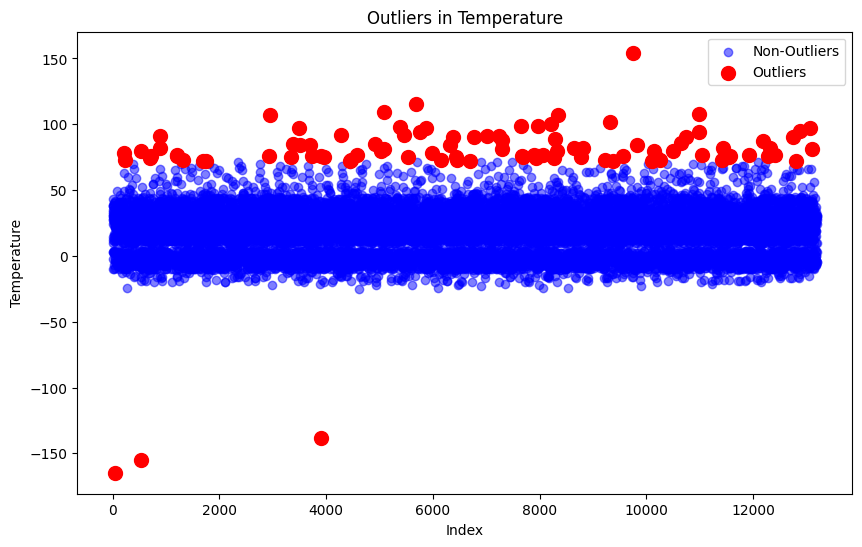

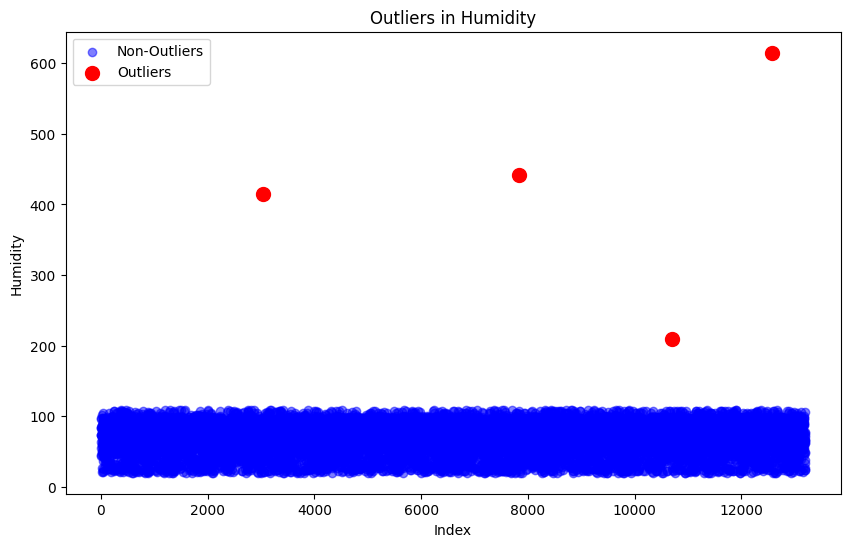

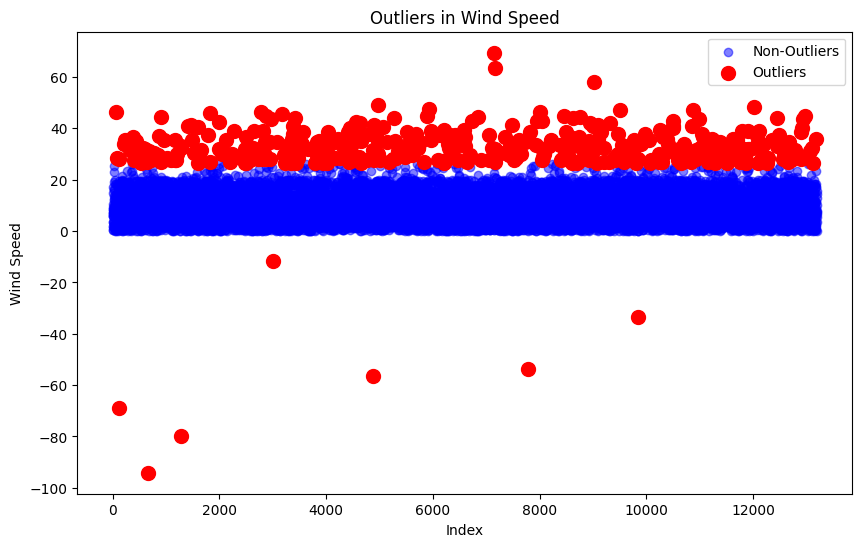

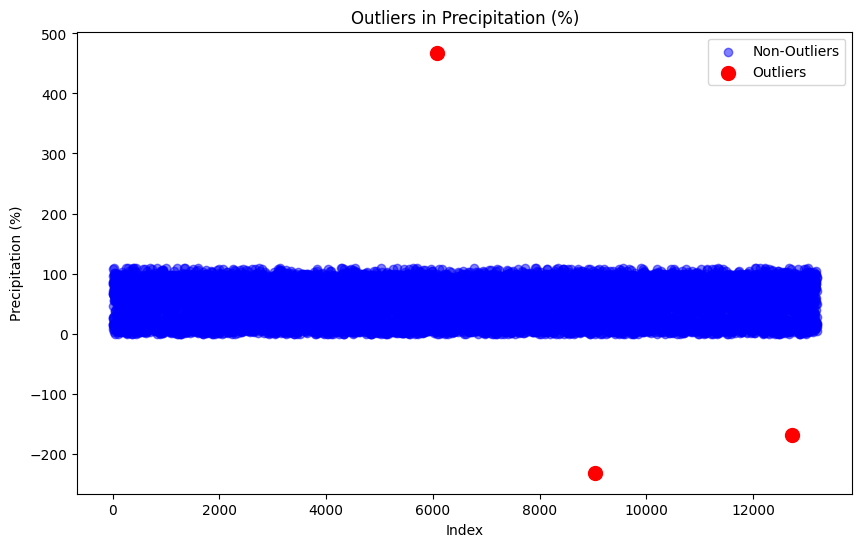

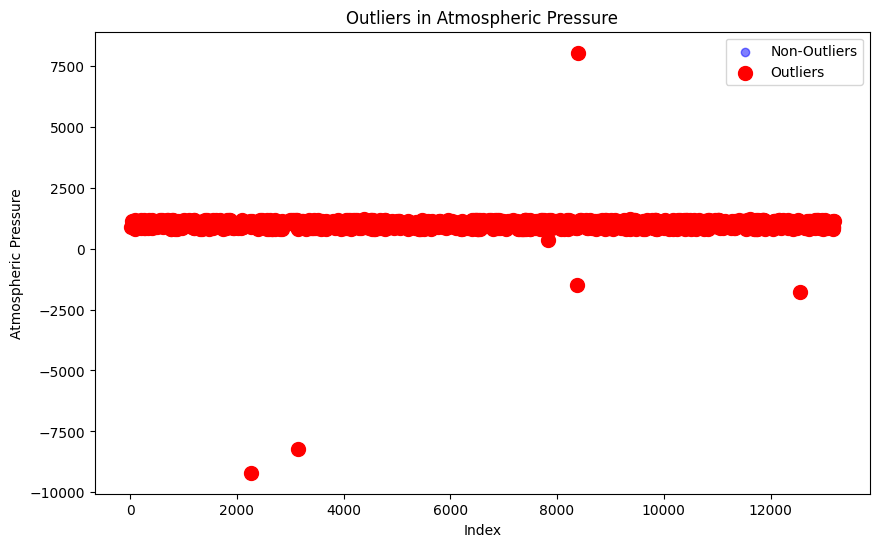

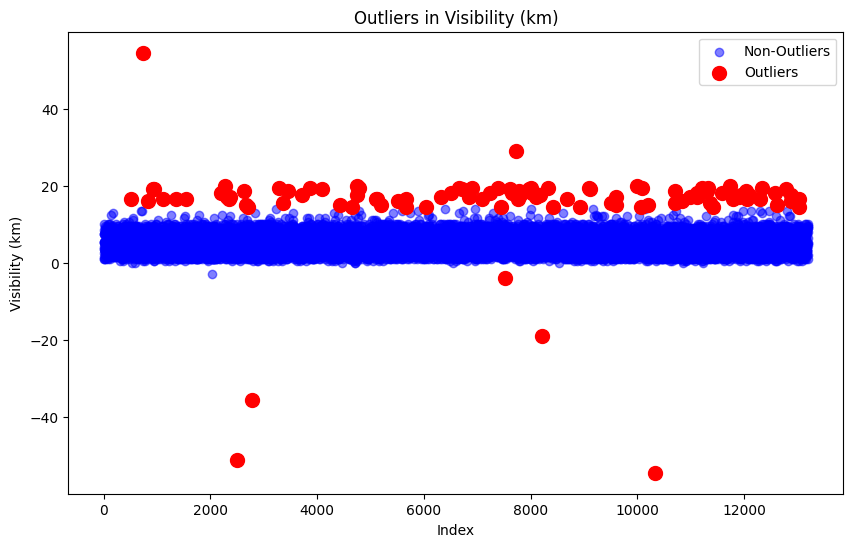

        Temperature      Humidity    Wind Speed  Precipitation (%)  \
count  11103.000000  11103.000000  11103.000000       11103.000000   
mean      18.945778     69.004864      9.116545          50.973460   
std       15.680294     19.115083      5.531784          31.715426   
min      -24.000000     20.000000      0.000000           0.000000   
25%        7.000000     59.000000      5.000000          18.000000   
50%       22.000000     70.000000      8.500000          54.000000   
75%       30.000000     83.000000     13.000000          80.000000   
max       71.000000    100.000000     26.000000         100.000000   

        Cloud Cover  Atmospheric Pressure      UV Index  Visibility (km)  \
count  11103.000000          11103.000000  11103.000000     11103.000000   
mean       1.128884           1006.235808      3.367829         5.124109   
std        0.905187             12.884447      3.302797         2.592008   
min        0.000000            962.880000      0.000000        -3

In [27]:

# Identifikovanie a odstraňovanie outlierov na základe IQR
def detect_and_remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifikácia outlierov
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Odstránenie outlierov
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_clean, outliers

# Aplikovanie na všetky číselné stĺpce
for column in numeric_columns:
    df, outliers = detect_and_remove_outliers(df, column)
    
    # Vizualizácia výsledkov
    plt.figure(figsize=(10, 6))
    
    plt.scatter(df.index, df[column], color='blue', label='Non-Outliers', alpha=0.5)
    plt.scatter(outliers.index, outliers[column], color='red', label='Outliers', s=100)
    
    plt.title(f"Outliers in {column}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()
    plt.show()

# Oprava neplatných hodnôt
df['Humidity'] = df['Humidity'].clip(lower=0, upper=100)
df['Precipitation (%)'] = df['Precipitation (%)'].clip(lower=0, upper=100)

# Odstrániť riadky, kde je UV Index väčší ako realistická maximálna hodnota
df = df[df['UV Index'] <= 11]
df = df[df['UV Index'] >= 0]



# Kontrola dát
print(df.describe())


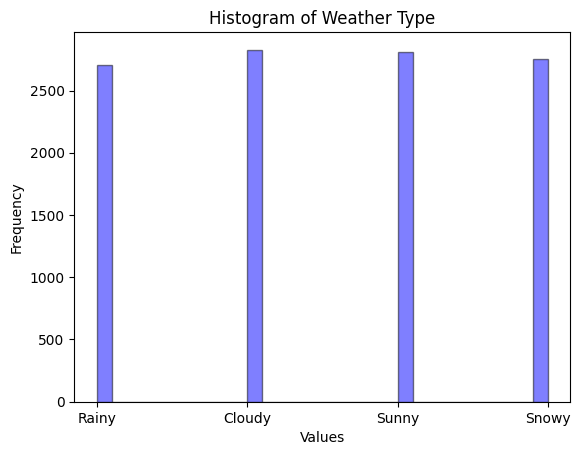

((7772, 13), (7772,), (1665, 13), (1665,), (1666, 13), (1666,))

In [28]:
X = df.drop(columns='Weather Type')
Y = df['Weather Type']

# Najprv rozdelíme dáta na trénovaciu a testovaciu množinu (60% tréning, 40% test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# Potom rozdelíme trénovaciu množinu na tréningovú a validačnú množinu (50% tréning, 50% validačná)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp , Y_temp, test_size=0.50, random_state=42)

plt.hist(df['Weather Type'], bins=30, color='blue', edgecolor='black', alpha=0.5)

plt.title('Histogram of Weather Type')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.show()

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

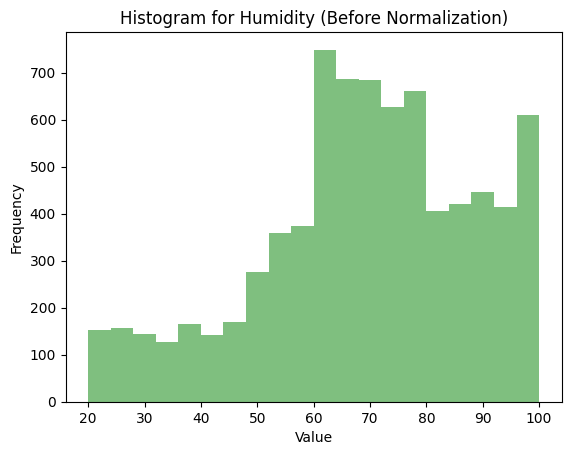

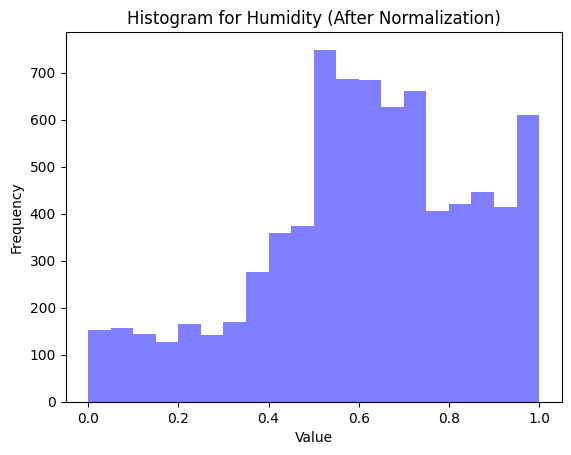

In [29]:
# Uloženie pôvodných dát pred normalizáciou
X_train_original = X_train.copy()  # Uložte pred aplikovaním MinMaxScaler

# Vytvorenie dátového rámca s názvami stĺpcov pre pôvodné dáta
X_train_original_df = pd.DataFrame(X_train_original, columns=X.columns)

# Zobrazenie histogramu pre stĺpec podľa názvu (napr. 'Humidity') pred normalizáciou
plt.hist(X_train_original_df['Humidity'], bins=20, color='green', alpha=0.5)
plt.title('Histogram for Humidity (Before Normalization)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


# Normalizácia dát
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Vytvorenie dátového rámca s názvami stĺpcov po normalizácii
X_train_df = pd.DataFrame(X_train, columns=X.columns)  # Uistite sa, že X má názvy stĺpcov

# Zobrazenie histogramu pre ten istý stĺpec po normalizácii (napr. 'Humidity')
plt.hist(X_train_df['Humidity'], bins=20, color='blue', alpha=0.5)
plt.title('Histogram for Humidity (After Normalization)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


Testovacia presnosť modelu: 0.9411764705882353


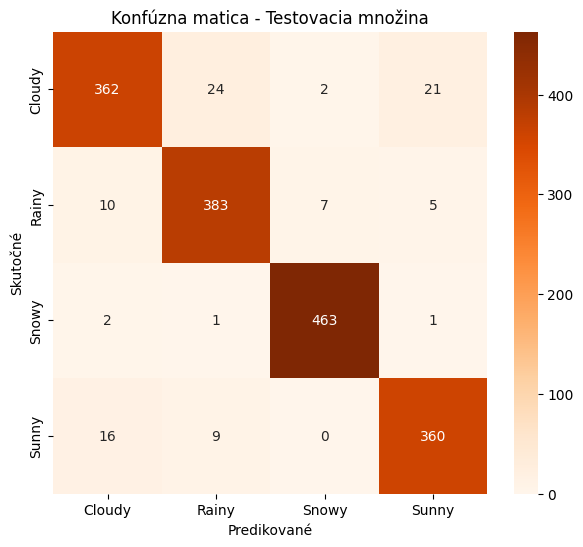

Validačná presnosť modelu: 0.9471471471471471


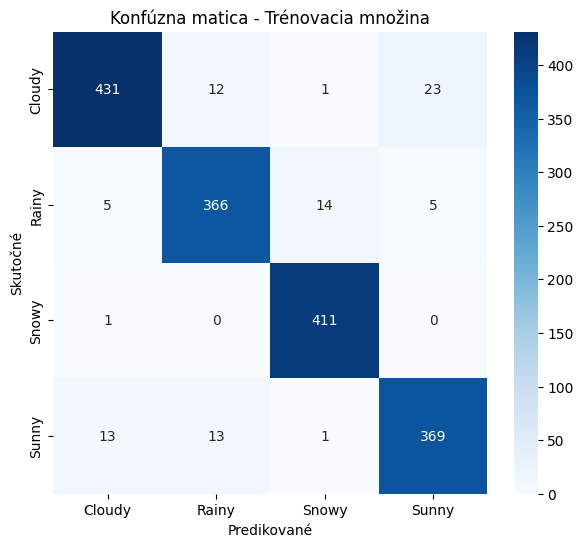

'\ny_pred = model.predict(X_test)\n\naccurracy = accuracy_score(Y_test, y_pred)\nprint(f"model accuracy: {accurracy}")\n\n# toto su len testovacie data\nconf_matrix = confusion_matrix(Y_test, y_pred)\nplt.figure(figsize=(7,6))\nsns.heatmap(conf_matrix, annot=True, fmt=\'d\', cmap=\'Oranges\', xticklabels=model.classes_, yticklabels=model.classes_)\nplt.title("Konfuzna matica")\nplt.xlabel("Predikovane")\nplt.ylabel("Aktualne")\nplt.show()\n'

In [30]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, Y_train)

# Natrénovanie modelu
model = LogisticRegression(max_iter=200)
model.fit(X_train, Y_train)

# Predikcie pre testovaciu množinu
y_pred_test = model.predict(X_test)
test_accuracy = accuracy_score(Y_test, y_pred_test)
print(f"Testovacia presnosť modelu: {test_accuracy}")

# Konfúzna matica pre testovaciu množinu
conf_matrix_test = confusion_matrix(Y_test, y_pred_test)
plt.figure(figsize=(7,6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Oranges', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfúzna matica - Testovacia množina")
plt.xlabel("Predikované")
plt.ylabel("Skutočné")
plt.show()

# Predikcie pre validačnú množinu
y_pred_val = model.predict(X_val)
val_accuracy = accuracy_score(Y_val, y_pred_val)
print(f"Validačná presnosť modelu: {val_accuracy}")

# Konfúzna matica pre validačnú množinu
conf_matrix_val = confusion_matrix(Y_val, y_pred_val)
plt.figure(figsize=(7,6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfúzna matica - Trénovacia množina")
plt.xlabel("Predikované")
plt.ylabel("Skutočné")
plt.show()

# 60-20-20 model accuracy: 0.9302937308198159
# 70-15-15 model accuracy: 0.9298655756867329
# 50-25-25 model accuracy: 0.9284712482468443
# 80-10-10 model accuracy: 0.9414941494149415





In [31]:
# korelacna matica
corr_matrix = px.imshow(df.corr())
corr_matrix.show()

C:\Users\mraff\AppData\Local\Temp\ipykernel_19232\2365527316.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



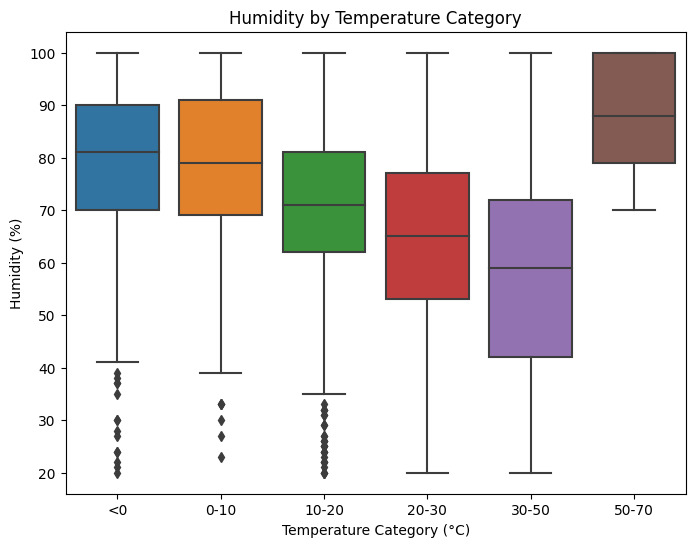

In [32]:
# 1. Teplota vs. Vlhkosť (box plot)

# Rozdelenie teploty do kategórií
df['Temperature Category'] = pd.cut(df['Temperature'], bins=[-30, 0, 10, 20, 30, 50, 70], labels=['<0', '0-10', '10-20', '20-30', '30-50', '50-70'])

plt.figure(figsize=(8,6))
sns.boxplot(x='Temperature Category', y='Humidity', data=df)
plt.title('Humidity by Temperature Category')
plt.xlabel('Temperature Category (°C)')
plt.ylabel('Humidity (%)')
plt.show()



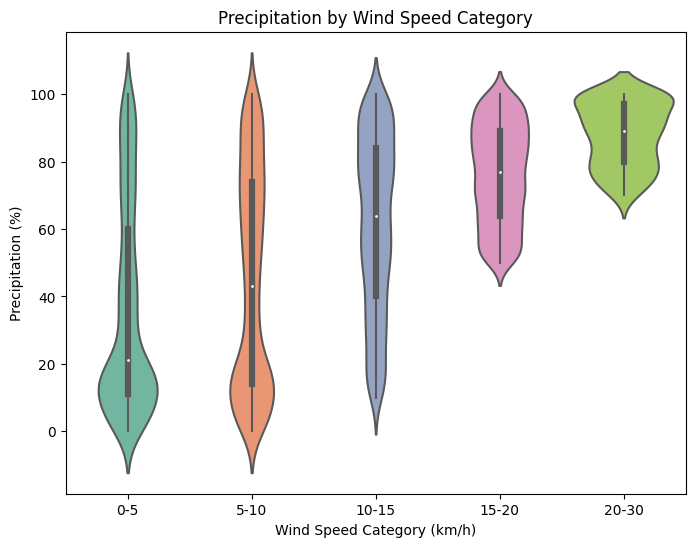

In [33]:
# 2. Vietor a Zrážky (violin plot)

df['Wind Speed Category'] = pd.cut(df['Wind Speed'], bins=[0, 5, 10, 15, 20, 30], labels=['0-5', '5-10', '10-15', '15-20', '20-30'])

plt.figure(figsize=(8,6))
sns.violinplot(x='Wind Speed Category', y='Precipitation (%)', data=df, palette='Set2')
plt.title('Precipitation by Wind Speed Category')
plt.xlabel('Wind Speed Category (km/h)')
plt.ylabel('Precipitation (%)')
plt.show()



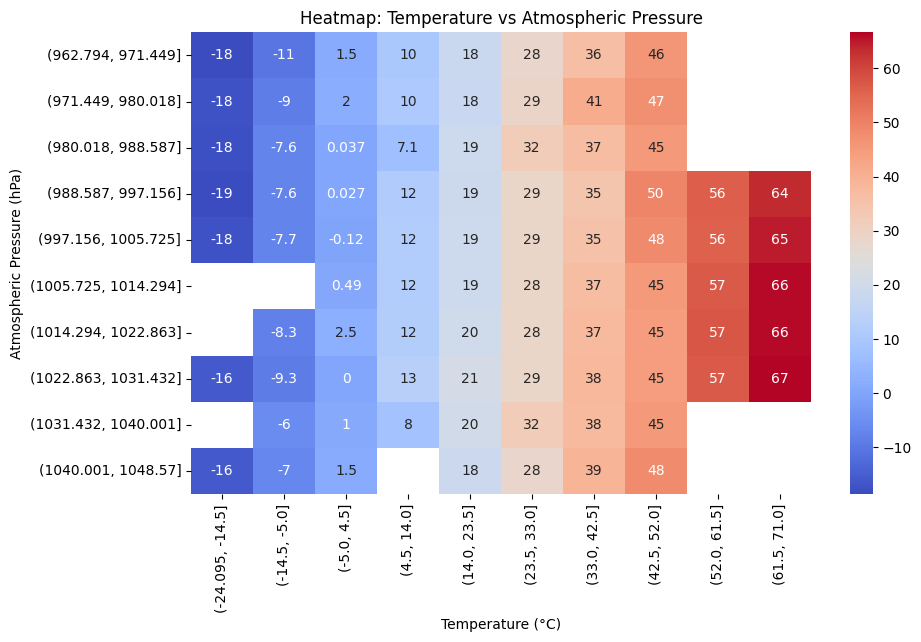

In [34]:
# 3. Atmosférický tlak vs. Teplota (heatmapa)

# Vytvárame mriežku pre atmosférický tlak a teplotu
pressure_temp = pd.pivot_table(df, values='Temperature', index=pd.cut(df['Atmospheric Pressure'], bins=10), columns=pd.cut(df['Temperature'], bins=10), aggfunc='mean')

plt.figure(figsize=(10,6))
sns.heatmap(pressure_temp, cmap='coolwarm', annot=True)
plt.title('Heatmap: Temperature vs Atmospheric Pressure')
plt.xlabel('Temperature (°C)')
plt.ylabel('Atmospheric Pressure (hPa)')
plt.show()


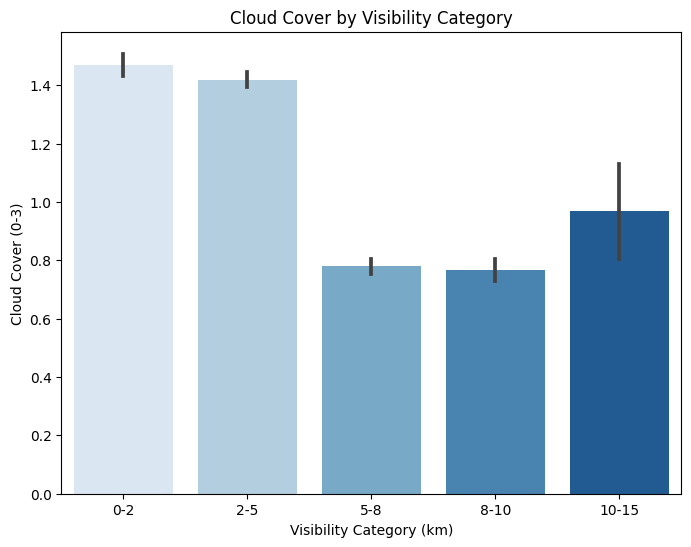

In [35]:
# 4. Oblačnosť vs. Viditeľnosť (bar plot)

# Rozdelenie viditeľnosti do kategórií
df['Visibility Category'] = pd.cut(df['Visibility (km)'], bins=[0, 2, 5, 8, 10, 15], labels=['0-2', '2-5', '5-8', '8-10', '10-15'])

plt.figure(figsize=(8,6))
sns.barplot(x='Visibility Category', y='Cloud Cover', data=df, palette='Blues')
plt.title('Cloud Cover by Visibility Category')
plt.xlabel('Visibility Category (km)')
plt.ylabel('Cloud Cover (0-3)')
plt.show()

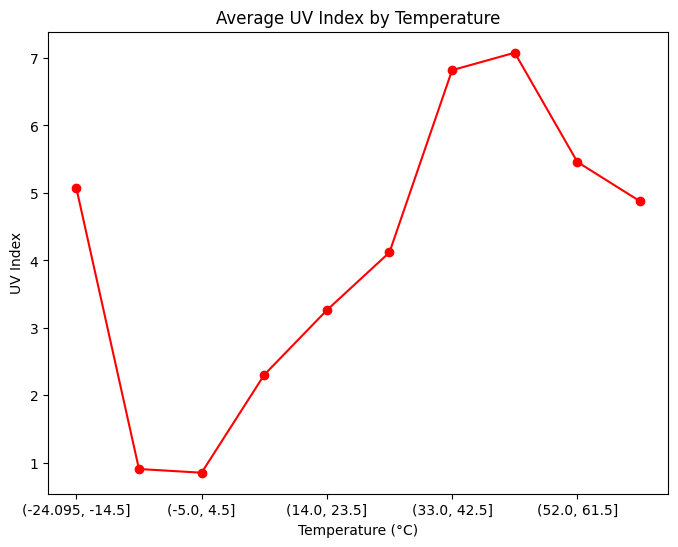

In [36]:
# 5. Teplota a UV Index (line plot)

# Priemerný UV Index pre teplotné kategórie
temp_uv = df.groupby(pd.cut(df['Temperature'], bins=10))['UV Index'].mean()

plt.figure(figsize=(8,6))
temp_uv.plot(kind='line', marker='o', color='red')
plt.title('Average UV Index by Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('UV Index')
plt.show()




In [37]:
# 1. Vytvorenie modelu na pretrénovanie
# Prevod Y na binárny formát
Y_train = pd.get_dummies(Y_train).values  # Konvertuje na binárny formát
Y_val = pd.get_dummies(Y_val).values
Y_test = pd.get_dummies(Y_test).values

# Kontrola tvaru Y
print(Y_train.shape)  # Tvar by mal byť (n_samples, n_classes)
print(Y_val.shape)
print(Y_test.shape)


(7772, 4)
(1665, 4)
(1666, 4)


Epoch 1/100


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7990 - loss: 0.5168 - val_accuracy: 0.9387 - val_loss: 0.1973
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.9431 - loss: 0.1961 - val_accuracy: 0.9550 - val_loss: 0.1529
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9567 - loss: 0.1489 - val_accuracy: 0.9489 - val_loss: 0.1553
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9517 - loss: 0.1515 - val_accuracy: 0.9688 - val_loss: 0.1039
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9606 - loss: 0.1377 - val_accuracy: 0.9598 - val_loss: 0.1254
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9583 - loss: 0.1228 - val_accuracy: 0.9658 - val_loss: 0.1081
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.9670 - loss: 0.1082 - val_accuracy: 0.9640 - val_loss: 0.1053
Epoch 8/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.9620 - loss: 0.1277 - val_accuracy: 

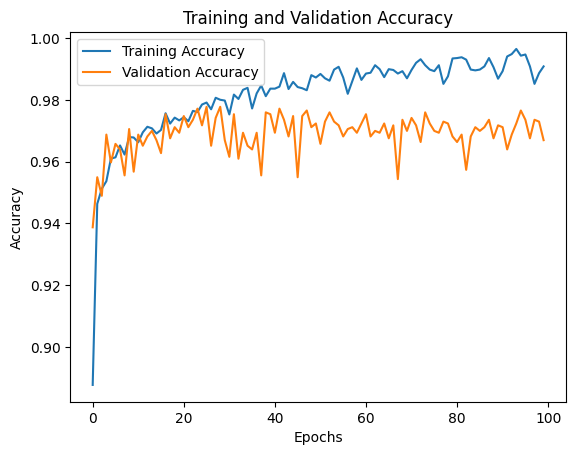

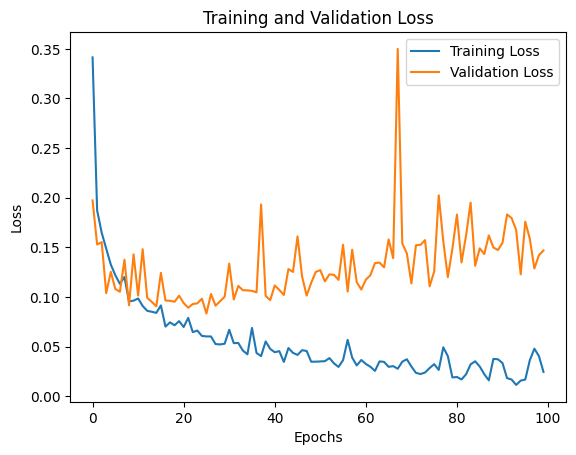

In [38]:

# Definícia modelu
def create_model():
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(Y_train.shape[1], activation='softmax'))
    
    # Kompilácia modelu
    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

# Trénovanie modelu
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val), batch_size=32)

# Zobrazenie priebehu trénovania
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Zobrazenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_accuracy}')

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.9701 - loss: 0.2219
Test accuracy: 0.9669867753982544


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


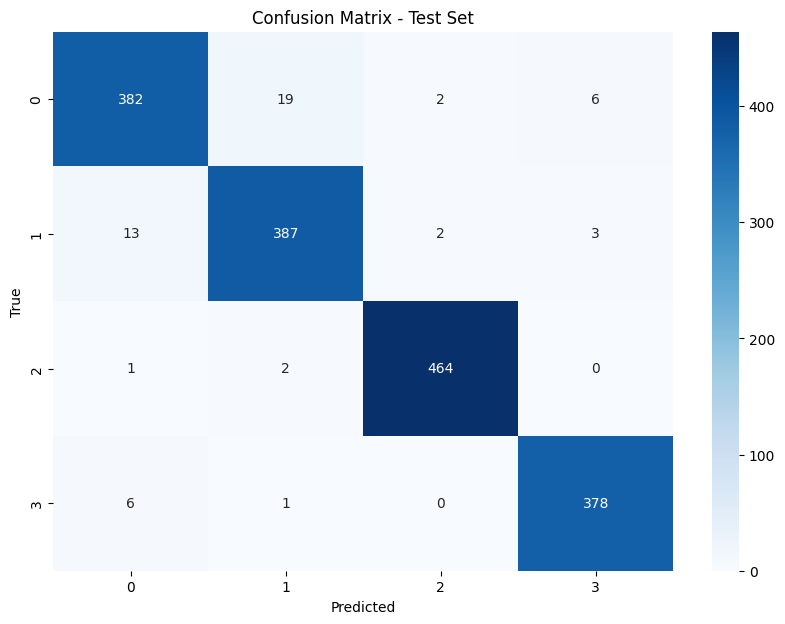

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


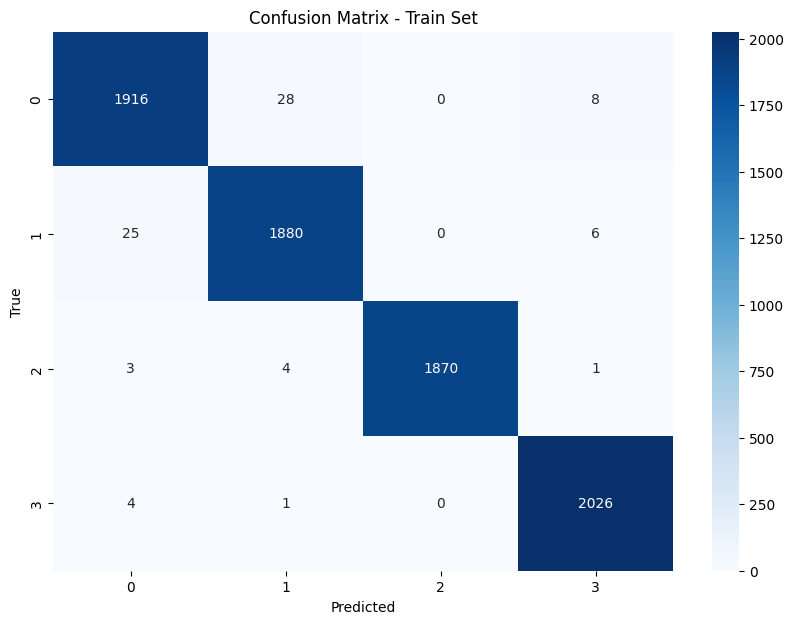

In [40]:
# Predpoveď na testovacích dátach
Y_pred_test = model.predict(X_test)
Y_pred_classes_test = Y_pred_test.argmax(axis=1)
Y_true_test = Y_test.argmax(axis=1)

# Vytvorenie konfúznej matice pre testovaciu množinu
conf_matrix_test = confusion_matrix(Y_true_test, Y_pred_classes_test)

# Vizuálne zobrazenie konfúznej matice pre testovaciu množinu
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Predpoveď na trénovacích dátach
Y_pred_train = model.predict(X_train)
Y_pred_classes_train = Y_pred_train.argmax(axis=1)
Y_true_train = Y_train.argmax(axis=1)

# Vytvorenie konfúznej matice pre trénovaciu množinu
conf_matrix_train = confusion_matrix(Y_true_train, Y_pred_classes_train)

# Vizuálne zobrazenie konfúznej matice pre trénovaciu množinu
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [41]:

# Definícia modelu s Dropout a parametrami pre neuróny a learning rate
def create_model2(n_neurons_1, n_neurons_2, learning_rate):
    model = Sequential()

    # Prvá vrstva s Dropout
    model.add(Dense(n_neurons_1, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.3))  # Dropout v prvej vrstve

    # Druhá vrstva s Dropout
    model.add(Dense(n_neurons_2, activation='relu'))
    model.add(Dropout(0.3))  # Dropout v druhej vrstve

    # Výstupná vrstva
    model.add(Dense(Y_train.shape[1], activation='softmax'))

    # Kompilácia modelu
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# N-fold cross-validation setup
n_splits = 5  # Počet folds pre cross-validáciu
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Grid search parametre
epochs_options = [50, 70]
learning_rate_options = [0.01, 0.001]
neurons_1_options = [64, 32]
neurons_2_options = [32, 16]

# Uchovanie najlepšieho skóre a parametrov
best_score = -np.inf
best_params = None

# Grid search cyklus
for epochs in epochs_options:
    for learning_rate in learning_rate_options:
        for n_neurons_1 in neurons_1_options:
            for n_neurons_2 in neurons_2_options:
                
                print(f'\nTesting combination: Epochs={epochs}, Learning Rate={learning_rate}, Neurons1={n_neurons_1}, Neurons2={n_neurons_2}')
                
                # Uchovanie skóre pre každý fold v danej kombinácii
                val_acc_per_fold = []
                val_loss_per_fold = []
                train_acc_per_fold = []

                # Cross-validácia pre aktuálnu kombináciu hyperparametrov
                for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
                    print(f'Fold {fold+1}/{n_splits}')
                    
                    # Rozdelenie dát pre aktuálny fold
                    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                    Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]
                    
                    # Vytvorenie nového modelu pre aktuálny fold
                    model = create_model2(n_neurons_1, n_neurons_2, learning_rate)
                    
                    # Early stopping callback
                    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                    
                    # Trénovanie modelu pre aktuálny fold
                    history = model.fit(X_train_fold, Y_train_fold, 
                                        epochs=epochs, 
                                        validation_data=(X_val_fold, Y_val_fold), 
                                        batch_size=32, 
                                        callbacks=[early_stopping],
                                        verbose=0)  # verbose=0 na vypnutie výpisov

                    # Vyhodnotenie trénovacej a validačnej množiny po trénovaní
                    train_loss, train_acc = model.evaluate(X_train_fold, Y_train_fold, verbose=0)
                    val_loss, val_acc = model.evaluate(X_val_fold, Y_val_fold, verbose=0)
                    
                    # Uloženie výsledkov pre aktuálny fold
                    train_acc_per_fold.append(train_acc)
                    val_acc_per_fold.append(val_acc)
                    val_loss_per_fold.append(val_loss)

                    print(f'Training Accuracy: {train_acc}, Validation Accuracy: {val_acc}')
                
                # Priemerná validácia presnosti pre všetky folds v danej kombinácii
                avg_train_acc = np.mean(train_acc_per_fold)
                avg_val_acc = np.mean(val_acc_per_fold)
                avg_val_loss = np.mean(val_loss_per_fold)

                print(f'Avg Training Accuracy for current params: {avg_train_acc}')
                print(f'Avg Validation Accuracy for current params: {avg_val_acc}, Avg Validation Loss: {avg_val_loss}')
                
                # Ak je aktuálny model lepší, uchováme ho
                if avg_val_acc > best_score:
                    best_score = avg_val_acc
                    best_params = {
                        'epochs': epochs,
                        'learning_rate': learning_rate,
                        'n_neurons_1': n_neurons_1,
                        'n_neurons_2': n_neurons_2
                    }

# Výsledky Grid Search
print(f'\nNajlepšie parametre z Grid Search: {best_params}')
print(f'Najlepšia priemerná validácia presnosti: {best_score}')




Testing combination: Epochs=50, Learning Rate=0.01, Neurons1=64, Neurons2=32
Fold 1/5


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Training Accuracy: 0.9588226079940796, Validation Accuracy: 0.962057888507843
Fold 2/5
Training Accuracy: 0.9604310989379883, Validation Accuracy: 0.9575562477111816
Fold 3/5


KeyboardInterrupt: 

Training Model 1: Epochs=50, Learning Rate=0.001, Neurons1=64, Neurons2=32
Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4659 - loss: 1.1871 - val_accuracy: 0.8598 - val_loss: 0.5349
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7874 - loss: 0.5907 - val_accuracy: 0.8868 - val_loss: 0.3911
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8541 - loss: 0.4608 - val_accuracy: 0.9074 - val_loss: 0.3318
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8868 - loss: 0.3815 - val_accuracy: 0.9183 - val_loss: 0.3011
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9057 - loss: 0.3270 - val_accuracy: 0.9293 - val_loss: 0.2720
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9127 - loss: 0.2989 - val_accuracy: 0.9254 - val_loss: 0.2577
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9175 - loss: 0.2797 - val_accuracy: 0.9363 - val_loss: 0.2349
Epoch 8/50
195/195 ━━━━━━━━━━

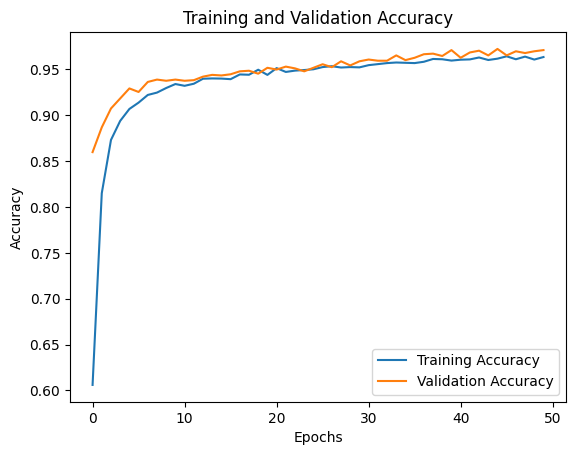

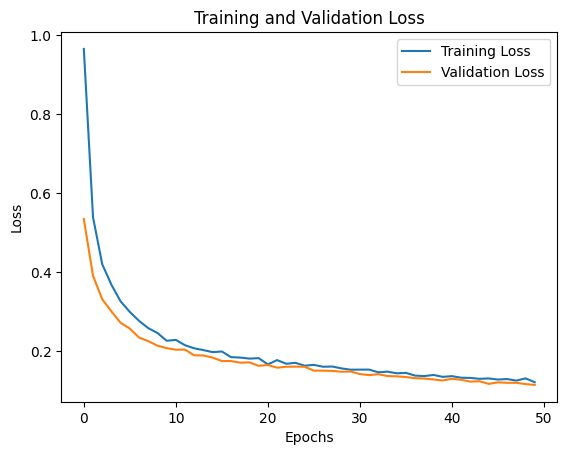

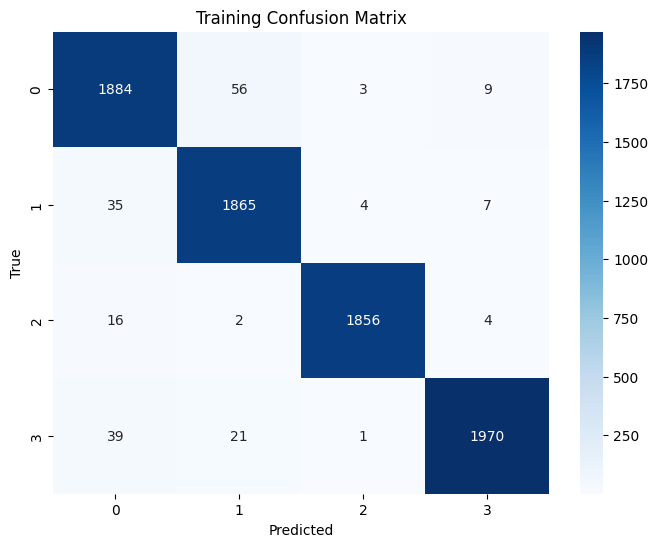

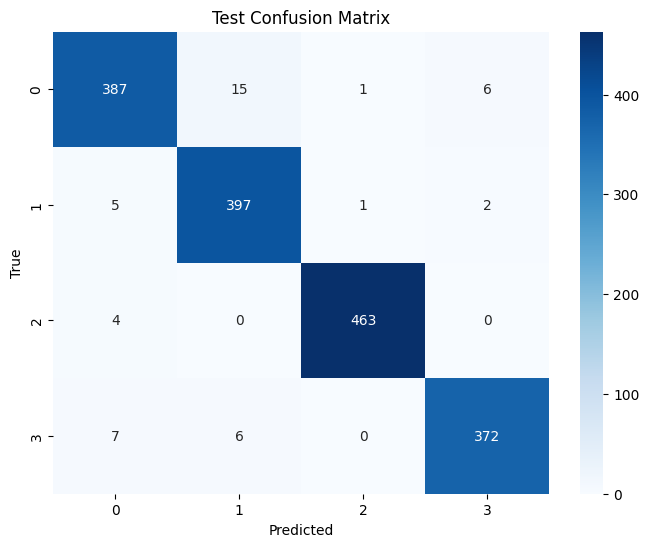

Training Model 2: Epochs=70, Learning Rate=0.01, Neurons1=32, Neurons2=16
Epoch 1/70


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6363 - loss: 0.8619 - val_accuracy: 0.9196 - val_loss: 0.2888
Epoch 2/70
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8781 - loss: 0.3856 - val_accuracy: 0.9222 - val_loss: 0.2665
Epoch 3/70
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9046 - loss: 0.3139 - val_accuracy: 0.9318 - val_loss: 0.2305
Epoch 4/70
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9081 - loss: 0.2887 - val_accuracy: 0.9344 - val_loss: 0.2225
Epoch 5/70
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9109 - loss: 0.2838 - val_accuracy: 0.9402 - val_loss: 0.2135
Epoch 6/70
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9174 - loss: 0.2861 - val_accuracy: 0.9344 - val_loss: 0.2185
Epoch 7/70
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9185 - loss: 0.2600 - val_accuracy: 0.9434 - val_loss: 0.2086
Epoch 8/70
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9241 - loss: 0.2575 - val_accuracy: 0.9479 - val_

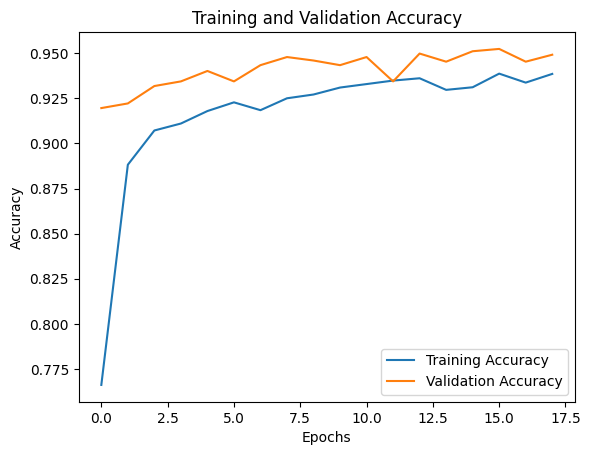

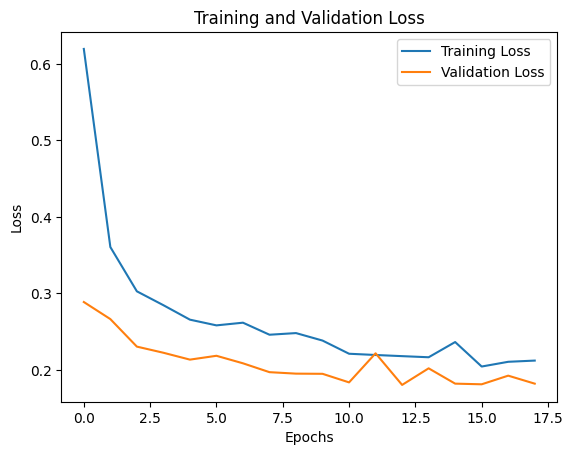

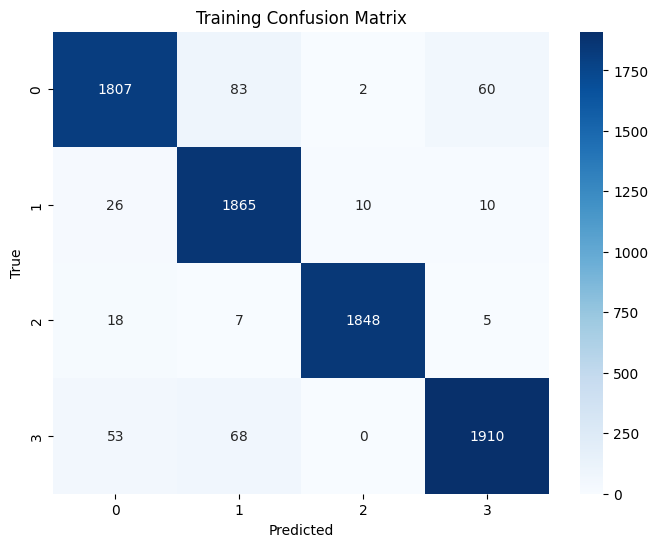

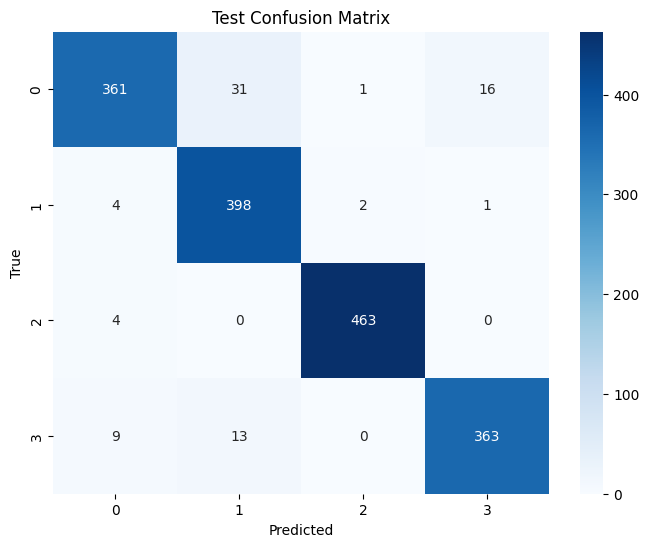

In [388]:
# Funkcia na vizualizáciu konfúznej matice
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Definícia funkcie na trénovanie a vyhodnotenie modelu
def train_and_evaluate_model(n_neurons_1, n_neurons_2, learning_rate, epochs):
    # Vytvorenie modelu
    model = create_model2(n_neurons_1, n_neurons_2, learning_rate)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Trénovanie modelu na celej trénovacej množine
    history = model.fit(X_train, Y_train,
                        epochs=epochs,
                        validation_split=0.2,  # Rozdelenie trénovacej množiny na trénovaciu a validačnú
                        batch_size=32,
                        callbacks=[early_stopping],
                        verbose=1)  # verbose=1 na zobrazenie priebehu trénovania

    # Vyhodnotenie modelu na trénovacej množine
    train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
    print(f'Training Loss: {train_loss}, Training Accuracy: {train_acc}')

    # Vyhodnotenie modelu na testovacej množine
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

    # Predikcia na trénovacej a testovacej množine
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Zobrazenie priebehu trénovania a validácie
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Zobrazenie konfúznej matice
    plot_confusion_matrix(Y_train, y_train_pred, title='Training Confusion Matrix')
    plot_confusion_matrix(Y_test, y_test_pred, title='Test Confusion Matrix')

# Prvý model
print("Training Model 1: Epochs=50, Learning Rate=0.001, Neurons1=64, Neurons2=32")
train_and_evaluate_model(n_neurons_1=64, n_neurons_2=32, learning_rate=0.001, epochs=50)

# Druhý model
print("Training Model 2: Epochs=70, Learning Rate=0.01, Neurons1=32, Neurons2=16")
train_and_evaluate_model(n_neurons_1=32, n_neurons_2=16, learning_rate=0.01, epochs=70)

In [389]:
# Inicializácia modelu
lin_reg = LinearRegression()

# Trénovanie modelu
lin_reg.fit(X_train, Y_train)

# Predikcia
y_pred = lin_reg.predict(X_test)

# Vyhodnotenie
mse_lin = mean_squared_error(Y_test, y_pred)
print(f'Mean Squared Error (Linear Regression): {mse_lin}')

Mean Squared Error (Linear Regression): 0.08139799560570032


In [390]:

# Inicializácia modelu
ridge_reg = Ridge(alpha=1.0)

# Trénovanie modelu
ridge_reg.fit(X_train, Y_train)

# Predikcia
y_pred = ridge_reg.predict(X_test)

# Vyhodnotenie
mse_ridge = mean_squared_error(Y_test, y_pred)
print(f'Mean Squared Error (Ridge Regression): {mse_ridge}')


Mean Squared Error (Ridge Regression): 0.08140907830141039


In [30]:

if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)

# Definícia modelov
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
    'Support Vector Machine': SVC(kernel='linear'),
    'Decision Tree': DecisionTreeClassifier()
}

# Uchovanie výsledkov
results = {}

# Trénovanie a hodnotenie modelov
for model_name, model in models.items():
    # Trénovanie modelu
    model.fit(X_train, y_train)
    
    # Predikcia na testovacej množine
    y_pred = model.predict(X_test)
    
    # Vyhodnotenie presnosti
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy

# Výpis výsledkov
print("\nPresnosť modelov:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.5f}")


Tvar y_train pred prevodom: (7772,)

Model: K-Nearest Neighbors
Confusion Matrix:
 [[379  19   1  10]
 [  9 384   9   3]
 [  4   1 462   0]
 [ 12   8   0 365]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93       409
           1       0.93      0.95      0.94       405
           2       0.98      0.99      0.98       467
           3       0.97      0.95      0.96       385

    accuracy                           0.95      1666
   macro avg       0.95      0.95      0.95      1666
weighted avg       0.95      0.95      0.95      1666


Model: Support Vector Machine
Confusion Matrix:
 [[366  19   3  21]
 [  3 397   1   4]
 [  3   0 463   1]
 [ 17   7   0 361]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92       409
           1       0.94      0.98      0.96       405
           2       0.99      0.99      0.99       467
           3 